In [18]:
%%HTML
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">[Toggle Code]</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path


import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()
from plotly.tools import FigureFactory as FF

import numpy as np
%matplotlib inline
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.stats as stats
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
rc("figure", figsize=(16.0, 8.0))
import os
fixed_color = {"ec": "#46a546"}

import daft
import pymc3
from pymc3 import Model, Normal, HalfNormal, Lognormal, Gamma
from pymc3 import find_MAP
from pymc3 import NUTS, sample, Slice, Metropolis
from pymc3.backends.base import merge_traces
from pymc3 import traceplot, summary, forestplot
from pymc3 import dot
import scipy.optimize



from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Mscl Scripts

In [2]:
def plot_exploratory_histogram(measure,acc,df):
    hist_data = []
    group_labels = []
    for val in df[measure].unique():
        if isinstance(val, str):
            y=df.loc[df[measure]==val,acc].as_matrix()
            y = y[~np.isnan(y)]
            
            hist_data.append(y)
            group_labels.append(val)

    fig = FF.create_distplot(hist_data,group_labels, bin_size=.02)
    fig['layout'].update(title=acc+'by '+measure)
    py.offline.iplot(fig)



In [3]:
def plot_exploratory_scatter(measure,acc,df):


    data = []

    ### Variable
    for val in df[measure].unique():
            data.append(go.Scatter(
                y=df.loc[df[measure]==val,acc].as_matrix(),
                x=df.loc[df[measure]==val,'PID'].as_matrix(),
                mode='markers',
                marker=dict(size=6,
                            line=dict(width=1)
                           ),
                name=val
                ))



    layout = go.Layout(
        title=acc+' by '+measure,
        hovermode='closest',
        xaxis=dict(
            title='Study ID',
            ticklen=5,
            zeroline=False,
            gridwidth=2,
        ),
        yaxis=dict(
            title='Decoding Accuracy',
            ticklen=5,
            gridwidth=2,
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)
    


In [4]:
def plot_box_plots(measure,acc,df):
    
    data = []

    ### Variable
    for val in df[measure].unique():
            data.append(go.Box(
                y=df.loc[df[measure]==val,acc].as_matrix(),
                name=val,
                boxpoints='all',
                jitter=0.5,
                whiskerwidth=0.2,
                marker=dict(size=2,
                            line=dict(width=1)
                           ),
                line=dict(width=1)
                ))
    

    layout = go.Layout(
        title='',
        yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        showline=True,
        autotick=True,
        ticks='',
        showticklabels=True
    ),
                width=600,
        height=600

    )

    fig = go.Figure(data=data,layout=layout)
    py.offline.iplot(fig)
    return(data)

#  Load Data 

In [5]:
##
cwd = os.getcwd()
datadir = cwd+'/../Data/'
print(datadir)
df= pd.read_csv(datadir+"Data_Classifications_v3.csv")


/home/bishop/cgagne/MVPA_Analysis/Meta_Analysis/../Data/


In [6]:
df[['PID','Title','Info-type','Accuracy-50','Accuracy-other','Roi-Search']].head(10)

PID                                              Title   Info-type  \
0   48  Decoding Effector-Dependent and Effector-Indep...    Response   
1   48  Decoding Effector-Dependent and Effector-Indep...    Response   
2   48  Decoding Effector-Dependent and Effector-Indep...    Response   
3   48  Decoding Effector-Dependent and Effector-Indep...    Response   
4   48  Decoding Effector-Dependent and Effector-Indep...    Response   
5   66  Representation of Spatial Information in Key A...  Perceptual   
6   48  Decoding Effector-Dependent and Effector-Indep...    Response   
7   66  Representation of Spatial Information in Key A...  Perceptual   
8   52  Decoding Temporal Structure in Music and Speec...  Perceptual   
9   50  Multivariate Activation and Connectivity Patte...  Perceptual   

   Accuracy-50  Accuracy-other        Roi-Search  
0        0.930             NaN               ROI  
1        0.930             NaN               ROI  
2        0.930             NaN               ROI  
3        0.920             NaN               ROI  
4        0.900             NaN               ROI  
5        0.900             NaN               ROI  
6        0.890             NaN               ROI  
7        0.880             NaN               ROI  
8        0.868             NaN  Searchlight Peak  
9        0.850             NaN  Searchlight Peak

In [7]:
##
## 
df_50 = df.loc[np.logical_not(np.isnan(df.loc[:,'Accuracy-50']))] # and at ROI's.. (searchlights take maximum )
#df_50 = df_50[['PID','Accuracy-50']]



In [8]:


data_50_paper = np.zeros((len(np.array(df_50['PID'].unique())),5))
data_50_paper[:,0] = np.array(df_50['PID'].unique())

# add CI intervals for study means. 
ii = 0
for i in df_50['PID'].unique():
    data_50_paper[ii,1]=np.mean(df_50.loc[df_50['PID']==i,'Accuracy-50'])
    data_50_paper[ii,2]=np.max(df_50.loc[df_50['PID']==i,'Accuracy-50'])
    data_50_paper[ii,3]=np.nanstd(df_50.loc[df_50['PID']==i,'Accuracy-50'])/np.sqrt(len(df_50.loc[df_50['PID']==i]))
    data_50_paper[ii,4]=len(df_50.loc[df_50['PID']==i])
    
    ii=ii+1
    
data_50_paper = pd.DataFrame(data_50_paper,columns=['PID','avg accuracy','max accuracy','se','n'])
data_50_paper['CI_high'] = data_50_paper['avg accuracy']+stats.t.ppf(.975,data_50_paper['n']-1, loc=0, scale=1)*data_50_paper['se']
data_50_paper['CI_low'] = data_50_paper['avg accuracy']-stats.t.ppf(.975,data_50_paper['n']-1, loc=0, scale=1)*data_50_paper['se']

In [9]:
for column in ['Roi-Search','Info-type']:
    for pid in data_50_paper['PID'].unique():
        levels = df.loc[df['PID']==pid,column].unique()
        if len(levels)==1: # only one unique category for the paper. 
            data_50_paper.loc[data_50_paper['PID']==pid,column]=levels[0]
        else:
            data_50_paper.loc[data_50_paper['PID']==pid,column]=np.nan
    

In [10]:
data_50_paper.head(20)

PID  avg accuracy  max accuracy        se   n   CI_high    CI_low  \
0    48      0.594583         0.930  0.012274  96  0.618950  0.570217   
1    66      0.821667         0.900  0.022536   6  0.879597  0.763736   
2    52      0.789333         0.868  0.019566   6  0.839628  0.739038   
3    50      0.850000         0.850  0.000000   1       NaN       NaN   
4    69      0.697778         0.850  0.031886   9  0.771308  0.624248   
5    54      0.756667         0.830  0.051926   3  0.980086  0.533248   
6    39      0.757000         0.820  0.009171  10  0.777745  0.736255   
7    31      0.689167         0.770  0.012498  12  0.716674  0.661659   
8    16      0.582333         0.750  0.022368  15  0.630307  0.534359   
9    18      0.608333         0.740  0.013172  24  0.635581  0.581085   
10   41      0.642692         0.730  0.009889  26  0.663060  0.622325   
11    9      0.582500         0.720  0.026487  12  0.640798  0.524202   
12   10      0.584167         0.720  0.011455  24  0.607864  0.560470   
13   61      0.710000         0.710  0.000000   1       NaN       NaN   
14   24      0.602500         0.700  0.029660   4  0.696890  0.508110   
15   27      0.607500         0.670  0.023015   4  0.680744  0.534256   
16   46      0.604286         0.660  0.004996  42  0.614375  0.594196   
17    6      0.587500         0.650  0.018498   4  0.646370  0.528630   
18   43      0.570000         0.650  0.018456   8  0.613642  0.526358   
19   55      0.582222         0.650  0.011197   9  0.608043  0.556401   

          Roi-Search   Info-type  
0                ROI    Response  
1                ROI  Perceptual  
2   Searchlight Peak  Perceptual  
3   Searchlight Peak  Perceptual  
4                ROI  Perceptual  
5                ROI        Rule  
6   Searchlight Peak       Value  
7                NaN        Rule  
8                ROI  Perceptual  
9                ROI        Rule  
10               ROI        Rule  
11  Searchlight Peak        Rule  
12               ROI  Perceptual  
13               ROI       Value  
14  Searchlight Peak         NaN  
15  Searchlight Peak        Rule  
16               ROI        Rule  
17  Searchlight Peak         NaN  
18               ROI  Perceptual  
19               ROI  Perceptual

## Design Matrix

In [12]:

### 

data = df.loc[df['Accuracy-50']>0]



## RANDOM EFFECT (study intercepts)
data= data.sort('PID')
uni = data['PID'].unique()
X = np.zeros((len(data),len(uni)))
for pp,pid in enumerate(uni): 
    X[:,pp] = (data['PID'].as_matrix()==pid).astype('float')
    

## Fixed EFFECTs

X2 = np.zeros(len(data))
X2labels=[]
variables = ['Info-type','Smoothing','Roi-Search','Classifier-type','Coregistration','Pattern-type','Pattern-normalization-type']
for var in variables:
    a= data[var].unique()
    a = [s for s in a if str(s) != 'nan'] # remove nan's
    for v in range(len(a)-1): # don't take last category
        x = (data[var]==a[v]).astype('float')
        
        X2 = np.vstack((X2,x))
        X2labels.append(a[v])
    
X2 = X2.T
X2 = X2[:,1::]
print X
print X.shape
print X2.shape
print X2
print X2labels

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(669, 52)
(669, 16)
[[ 1.  0.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  0.  1.]]
['Response', 'Perceptual', 'Rule', 'unsmooth', 'ROI', 'svm-lin', 'LDA', 'LogReg', 'GNB', 'svm-nonlin', 'Native Space', 'Multi-Trial Multi-Time Point', 'Single Trial Multi-Time Point', 'Multi-Trial Single-Time Point', 'None', 'Normalized Temporally']


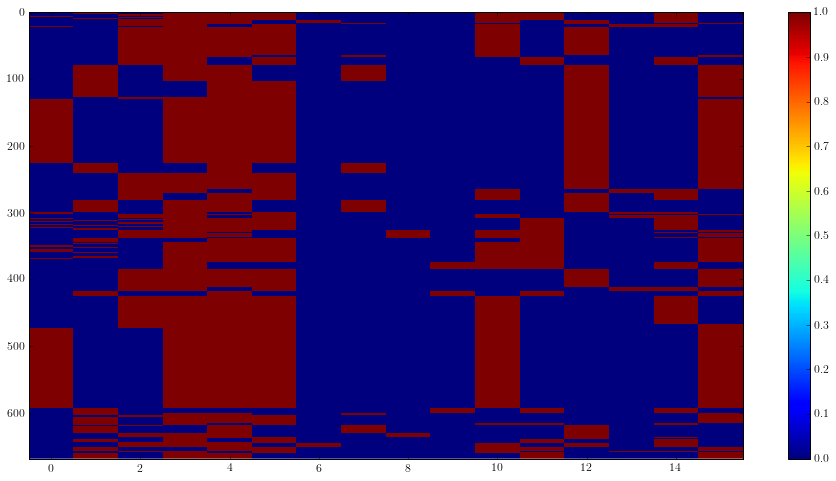

In [20]:
plt.imshow(X2,aspect='auto',interpolation='None')
plt.colorbar()

In [25]:
X2.shape

(669, 16)

In [27]:
X2[:,3]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [28]:
X2[:,4]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [26]:
np.corrcoef(X2[:,3],X2[:,4])

array([[ 1.        , -0.03084194],
       [-0.03084194,  1.        ]])

In [22]:
X2labels

['Response',
 'Perceptual',
 'Rule',
 'unsmooth',
 'ROI',
 'svm-lin',
 'LDA',
 'LogReg',
 'GNB',
 'svm-nonlin',
 'Native Space',
 'Multi-Trial Multi-Time Point',
 'Single Trial Multi-Time Point',
 'Multi-Trial Single-Time Point',
 'None',
 'Normalized Temporally']

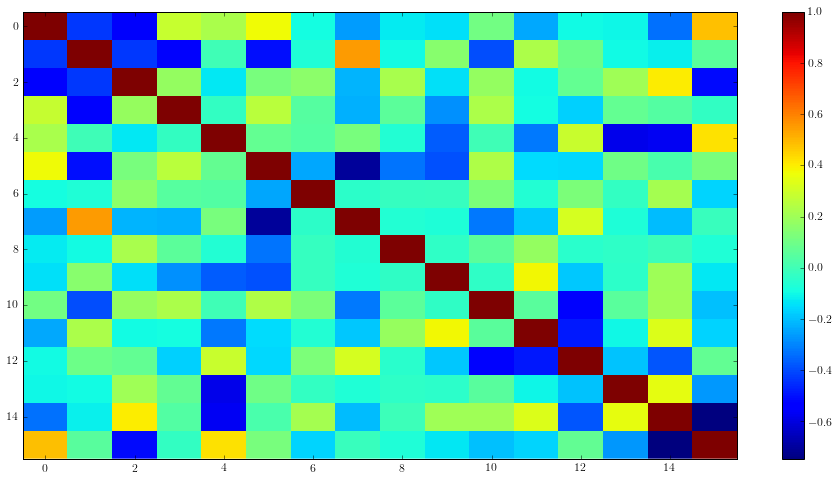

In [19]:
plt.imshow(np.corrcoef(X2.T),aspect='auto',interpolation='None')
plt.colorbar()

## Bayesian Estimation 

In [31]:
import pickle
#os.remove('trace_linear_model2.p')
if os.path.isfile('trace_linear_model2.p'):
    trace = pickle.load( open( "trace_linear_model2.p", "rb" ) )
    
else:
    linear_model=Model()
    with linear_model:

        # Top level 
        accpop = Normal('accpop', mu=.5, sd=1)
        sigmap= HalfNormal('sigmap', sd=1)

        #
        studyacc_mean = Normal('studyacc_mean', mu=accpop, sd=sigmap, shape=len(uni))
        sigmas= HalfNormal('sigmas', sd=1)

        betas = Normal('betas', mu=0, sd=1, shape=X2.shape[1])

        muu = dot(X,studyacc_mean) + dot(X2,betas)


        acc = Normal('acc', mu=muu, sd=sigmas, observed=data['Accuracy-50'])

        start = find_MAP(fmin=scipy.optimize.fmin_powell)
        trace = sample(1000) 
        pickle.dump( trace, open( "trace_linear_model2.p", "wb" ) )

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '6072' (I am process '13658')


### Posterior Plots 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d40484350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1d38f770d0>]], dtype=object)

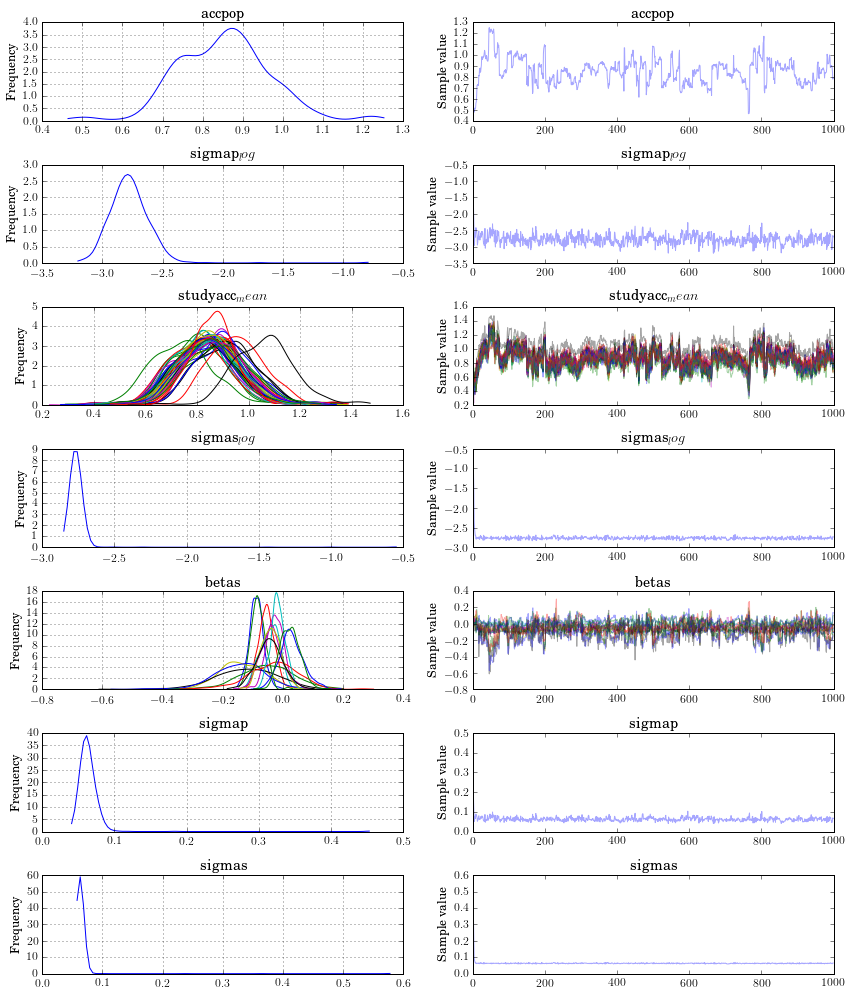

In [32]:
traceplot(trace)

### Parameter Estimates

In [33]:
bayes_pooled_estimates = trace['betas'].mean(0)
bayes_pooled_err = np.percentile(trace['betas'],97.5,axis=0)-trace['betas'].mean(0)

data = [
    go.Scatter(
        x=np.arange(np.shape(trace['betas'])[1]),
        y=bayes_pooled_estimates,
        error_y=dict(
            type='data',
            array=bayes_pooled_err,
            visible=True
        )
    )
]
layout = dict(
        xaxis = dict(
            ticktext = X2labels,
            tickvals = np.arange(len(X2labels))
        )
    ) 
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

## Model: Just Classifier Type and ROI-Search

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(669, 52)
(669, 6)
[[ 1.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  1.]
 ..., 
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]]
['svm-lin', 'LDA', 'LogReg', 'GNB', 'svm-nonlin', 'ROI']


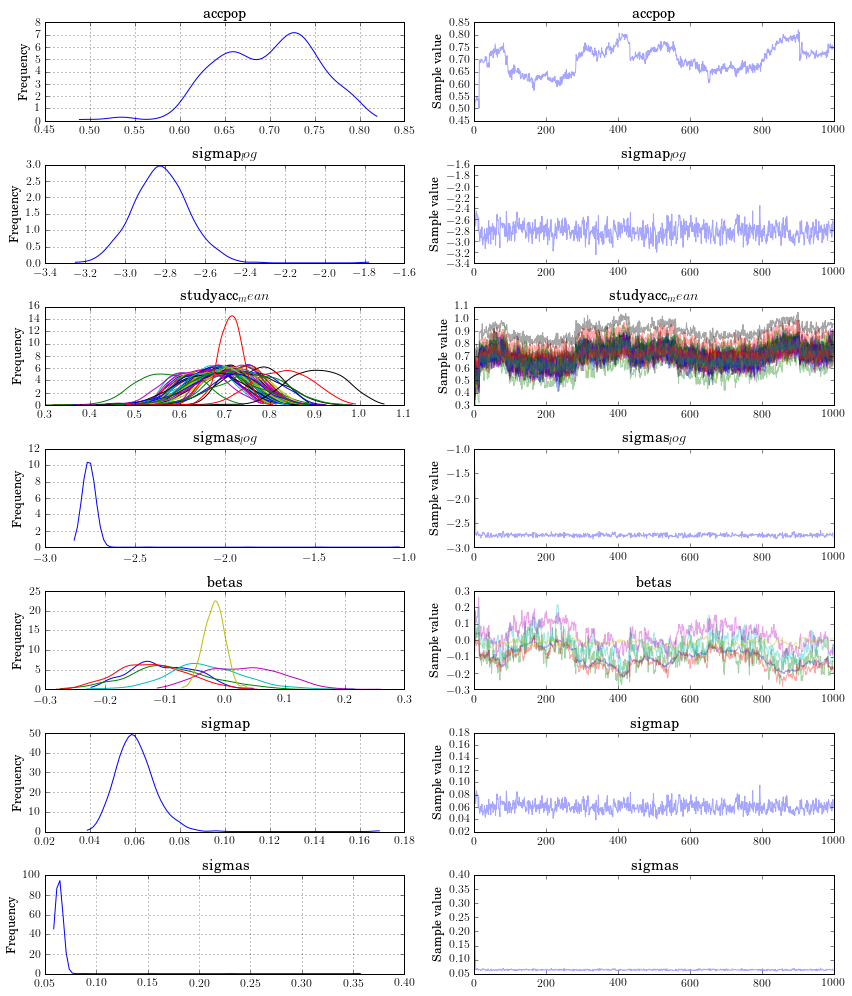

In [34]:

### 

data = df.loc[df['Accuracy-50']>0]



## RANDOM EFFECT (study intercepts)
data= data.sort('PID')
uni = data['PID'].unique()
X = np.zeros((len(data),len(uni)))
for pp,pid in enumerate(uni): 
    X[:,pp] = (data['PID'].as_matrix()==pid).astype('float')
    

## Fixed EFFECTs

X2 = np.zeros(len(data))
X2labels=[]
variables = ['Classifier-type','Roi-Search']
for var in variables:
    a= data[var].unique()
    a = [s for s in a if str(s) != 'nan'] # remove nan's
    for v in range(len(a)-1): # don't take last category
        x = (data[var]==a[v]).astype('float')
        
        X2 = np.vstack((X2,x))
        X2labels.append(a[v])
    
X2 = X2.T
X2 = X2[:,1::]
print X
print X.shape
print X2.shape
print X2
print X2labels

#os.remove('trace_linear_model2.p')
if os.path.isfile('trace_linear_model2c.p'):
    trace = pickle.load( open( "trace_linear_model2c.p", "rb" ) )
    
else:
    linear_model=Model()
    with linear_model:

        # Top level 
        accpop = Normal('accpop', mu=.5, sd=1)
        sigmap= HalfNormal('sigmap', sd=1)

        #
        studyacc_mean = Normal('studyacc_mean', mu=accpop, sd=sigmap, shape=len(uni))
        sigmas= HalfNormal('sigmas', sd=1)

        betas = Normal('betas', mu=0, sd=1, shape=X2.shape[1])

        muu = dot(X,studyacc_mean) + dot(X2,betas)


        acc = Normal('acc', mu=muu, sd=sigmas, observed=data['Accuracy-50'])

        start = find_MAP(fmin=scipy.optimize.fmin_powell)
        trace = sample(1000) 
        pickle.dump( trace, open( "trace_linear_model2c.p", "wb" ) )
        
traceplot(trace)



bayes_pooled_estimates = trace['betas'].mean(0)
bayes_pooled_err = np.percentile(trace['betas'],97.5,axis=0)-trace['betas'].mean(0)

data = [
    go.Scatter(
        x=np.arange(np.shape(trace['betas'])[1]),
        y=bayes_pooled_estimates,
        error_y=dict(
            type='data',
            array=bayes_pooled_err,
            visible=True
        )
    )
]
layout = dict(
        xaxis = dict(
            ticktext = X2labels,
            tickvals = np.arange(len(X2labels))
        )
    ) 
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

## Model: Linear Over-parameterized

In [35]:

### 

data = df.loc[df['Accuracy-50']>0]



## RANDOM EFFECT (study intercepts)
data= data.sort('PID')
uni = data['PID'].unique()
X = np.zeros((len(data),len(uni)))
for pp,pid in enumerate(uni): 
    X[:,pp] = (data['PID'].as_matrix()==pid).astype('float')
    

## Fixed EFFECTs

X2 = np.zeros(len(data))
X2labels=[]
variables = ['Info-type','Smoothing','Roi-Search','Classifier-type','Coregistration','Pattern-type','Pattern-normalization-type']
for var in variables:
    a= data[var].unique()
    a = [s for s in a if str(s) != 'nan'] # remove nan's
    for v in range(len(a)): # don't take last category
        x = (data[var]==a[v]).astype('float')
        
        X2 = np.vstack((X2,x))
        X2labels.append(a[v])
    
X2 = X2.T
X2 = X2[:,1::]
print X
print X.shape
print X2.shape
print X2
print X2labels

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(669, 52)
(669, 23)
[[ 1.  0.  0. ...,  1.  0.  0.]
 [ 0.  1.  0. ...,  1.  0.  0.]
 [ 0.  1.  0. ...,  1.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]]
['Response', 'Perceptual', 'Rule', 'Value', 'unsmooth', 'smoothed', 'ROI', 'Searchlight Peak', 'svm-lin', 'LDA', 'LogReg', 'GNB', 'svm-nonlin', 'correlation', 'Native Space', 'coregistered', 'Multi-Trial Multi-Time Point', 'Single Trial Multi-Time Point', 'Multi-Trial Single-Time Point', 'Single Trial Single-Time Point', 'None', 'Normalized Temporally', 'Normalized Spatially']


In [36]:
#os.remove('trace_linear_model2.p')
if os.path.isfile('trace_linear_model2b.p'):
    trace = pickle.load( open( "trace_linear_model2b.p", "rb" ) )
    
else:
    linear_model=Model()
    with linear_model:

        # Top level 
        accpop = Normal('accpop', mu=.5, sd=1)
        sigmap= HalfNormal('sigmap', sd=1)

        #
        studyacc_mean = Normal('studyacc_mean', mu=accpop, sd=sigmap, shape=len(uni))
        sigmas= HalfNormal('sigmas', sd=1)

        betas = Normal('betas', mu=0, sd=1, shape=X2.shape[1])

        muu = dot(X,studyacc_mean) + dot(X2,betas)


        acc = Normal('acc', mu=muu, sd=sigmas, observed=data['Accuracy-50'])

        start = find_MAP(fmin=scipy.optimize.fmin_powell)
        trace = sample(1000) 
        pickle.dump( trace, open( "trace_linear_model2b.p", "wb" ) )


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d40259850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1d3582fb50>]], dtype=object)

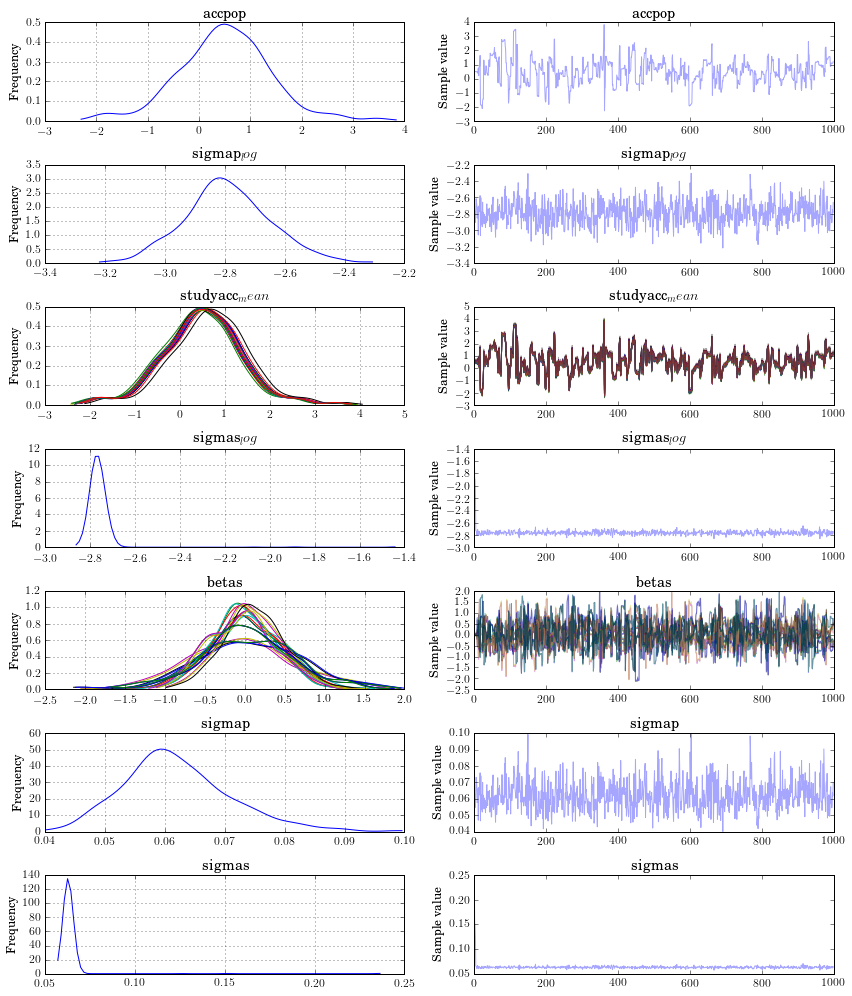

In [37]:
traceplot(trace)